In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [5]:
DATASET_ID = 'BIRD_DB_Vireo_cassinii'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'cassins.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/BIRD_DB_Vireo_cassinii/cassins.pickle')

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

,start_time,end_time,labels,indv,indvi,subject_importance,key,audio,rate,spectrogram
0,9.842790,10.105938,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.19927763130383222, -0.2129138251615996, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3059005, 0.4..."
1,72.031245,72.346332,ah,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.12207342570633199, -0.09996911527363203, -...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.12574787, 0.12236..."
2,74.130176,74.376012,bz,ORA,0,Primary subject,2014-05-29_10-10-00-000000,"[-0.0889848557398444, -0.06770700742932487, -0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2822944, 0.0..."


In [10]:
len(syllable_df)

67032

In [11]:
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

### cluster

In [12]:
from avgn.visualization.projections import scatter_spec
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [13]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [14]:
import hdbscan

In [15]:
from avgn.visualization.projections import draw_projection_transitions

In [16]:
syllable_df = syllable_df.sort_values(by=["key", "start_time"])
print(len(syllable_df))
specs = [norm(i) for i in syllable_df.spectrogram.values]

# sequencing
syllable_df["syllables_sequence_id"] = None
syllable_df["syllables_sequence_pos"] = None
for ki, key in enumerate(syllable_df.key.unique()):
    syllable_df.loc[syllable_df.key == key, "syllables_sequence_id"] = ki
    syllable_df.loc[syllable_df.key == key, "syllables_sequence_pos"] = np.arange(
        np.sum(syllable_df.key == key)
    )

67032


In [17]:
# umap
specs_flattened = flatten_spectrograms(specs)
cuml_umap = cumlUMAP(min_dist=0.5)
z = list(cuml_umap.fit_transform(specs_flattened))
syllable_df["umap"] = z

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  This is separate from the ipykernel package so we can avoid doing imports until
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  after removing the cwd from sys.path.


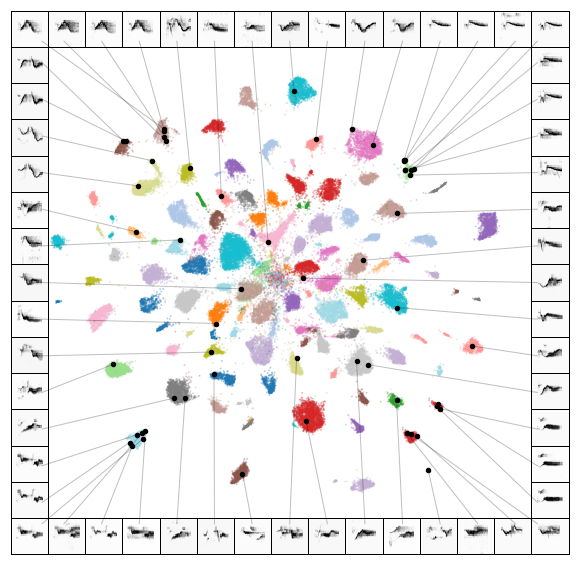

In [18]:
# plot
scatter_spec(
    np.vstack(z),
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': list(syllable_df.labels.values),
        'alpha':0.25,
        's': 1,
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True,
    #ax= ax[0,indvi]
);

In [23]:
??draw_projection_transitions

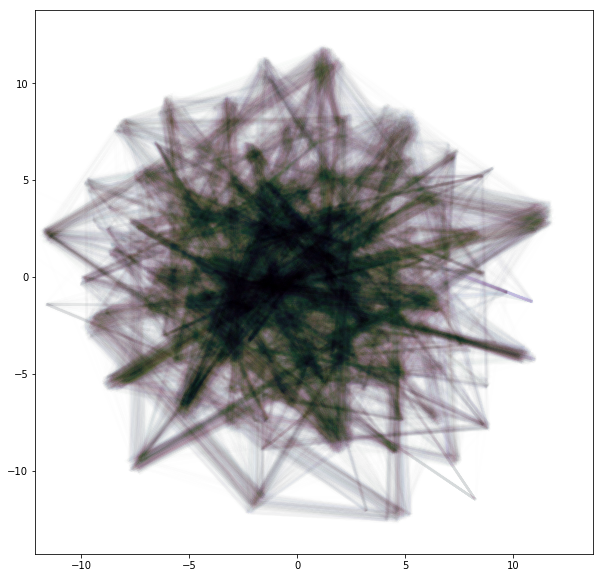

In [26]:
draw_projection_transitions(
    projections=np.array(list(syllable_df['umap'].values)),
    sequence_ids=syllable_df["syllables_sequence_id"],
    sequence_pos=syllable_df["syllables_sequence_pos"],
    #ax=ax[1,indvi],
    alpha = 0.0025
)

### label

In [20]:
from sklearn.cluster import MiniBatchKMeans

In [21]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(len(z) * 0.001), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
)
clusterer.fit(z);
syllable_df['hdbscan_labels'] = clusterer.labels_

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


In [22]:
# HDBSCAN 
specs = [norm(i) for i in syllable_df.spectrogram.values]
specs_flattened = flatten_spectrograms(specs)

In [27]:
# kmeans
# get number of possible states
n_states = len(syllable_df.labels.unique())

kmeans = MiniBatchKMeans(n_clusters = n_states).fit(z)
syllable_df['kmeans_labels'] = kmeans.labels_

In [28]:
# kmeans data
kmeans = MiniBatchKMeans(n_clusters = n_states).fit(specs_flattened)
syllable_df['kmeans__pix_labels'] = kmeans.labels_

### plot

In [39]:
ensure_dir(FIGURE_DIR / 'cassins_cluster')

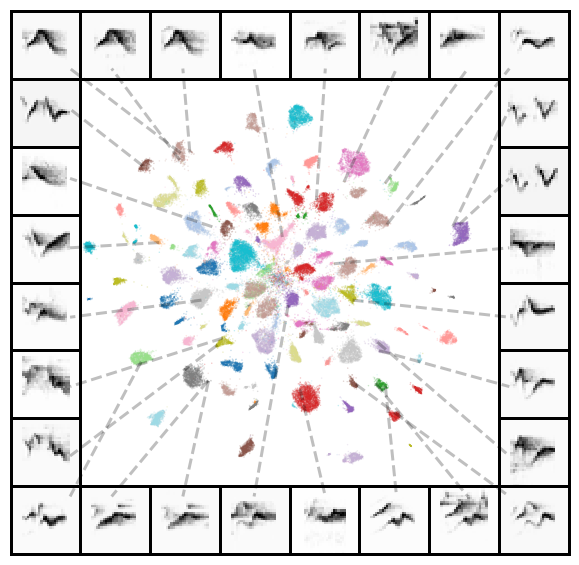

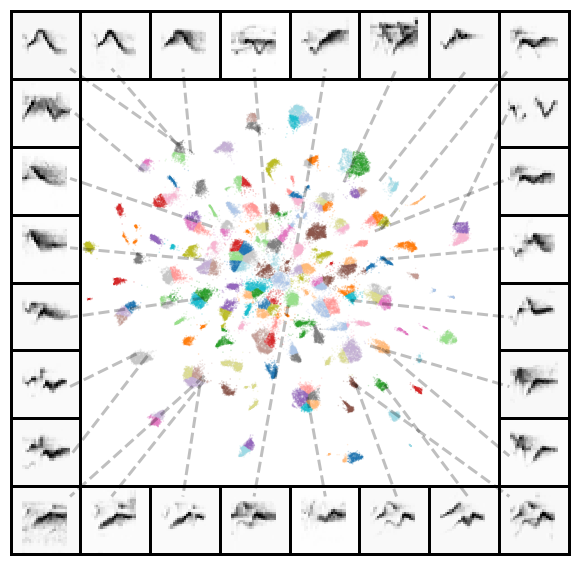

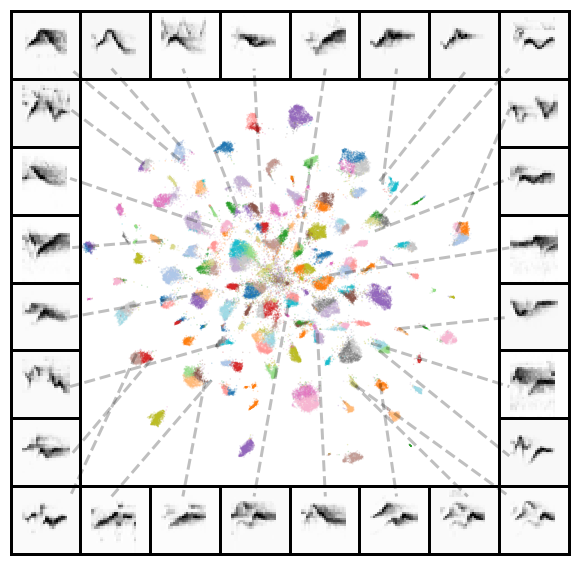

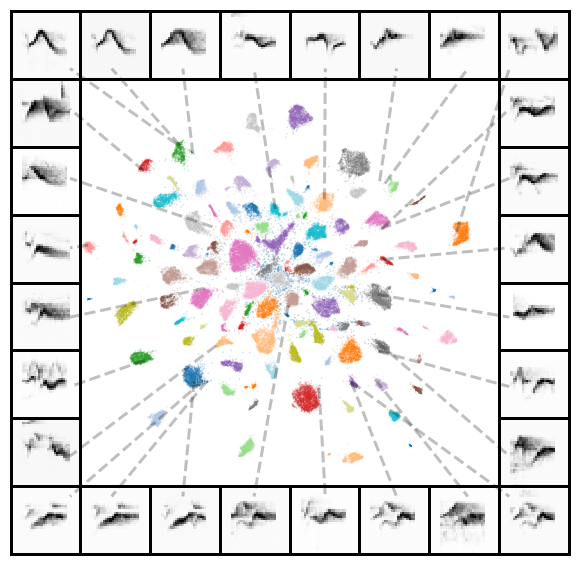

In [41]:
for i, (lablab, lab) in enumerate(
    tqdm([
        ["Ground Truth", "labels"],
        ['KMeans/UMAP',"kmeans_labels"],
        ["KMeans" , "kmeans__pix_labels"],
        ["HDBSCAN/UMAP", "hdbscan_labels"],
    ]
)):
    ax = axs.flatten()[i]    
    nex = -1
    scatter_spec(
        np.array(list(syllable_df["umap"].values)),
        specs = syllable_df.spectrogram.values,
        column_size=8,
        #x_range = [-4.5,4],
        #y_range = [-4.5,5.5],
        pal_color="hls",
        color_points=False,
        enlarge_points=0,
        figsize=(10, 10),
        range_pad = 0.1,
        scatter_kwargs = {
            'labels': list(syllable_df[lab].values),
            'alpha':0.25,
            's': 0.25,
            'show_legend': False,
            'color_palette':'tab20'
        },
        matshow_kwargs = {
            'cmap': plt.cm.Greys
        },
        line_kwargs = {
            'lw':3,
            'ls':"dashed",
            'alpha':0.25,
        },
        draw_lines=True,
        n_subset= 1000,
        border_line_width = 3,
    );
    
    
    save_fig(FIGURE_DIR / 'cassins_cluster' / ('clustering_example_cassin_' + lab), dpi=300, save_jpg=True, save_png=True)
    plt.show()
